In [1]:
import numpy as np
from shapely.plotting import plot_polygon

import matplotlib.pyplot as plt
import matplotlib.style as style

style.use(
    "https://raw.githubusercontent.com/dominik-strutz/dotfiles/main/mystyle.mplstyle"
)
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# Cmap with only blue and deacreasig alpha
cmap1 = LinearSegmentedColormap.from_list(
    "mycmap",
    [
        "cornflowerblue",
        "mediumblue",
    ],
)

blue_cmap = cmap1
blue_cmap = blue_cmap(np.arange(blue_cmap.N))
blue_cmap[:, -1] = np.linspace(0, 1, blue_cmap.shape[0]) * 0.8
blue_cmap[:, :3] = [0.0, 0.0, 1.0]
blue_cmap = ListedColormap(blue_cmap)


cmap2 = LinearSegmentedColormap.from_list(
    "mycmap",
    [
        "salmon",
        "firebrick",
    ],
)

red_cmap = cmap2
red_cmap = red_cmap(np.arange(red_cmap.N))
red_cmap[:, -1] = np.linspace(0, 1, red_cmap.shape[0]) * 1.0
# red_cmap[:, :3] = [1.0, 0.0, 0.0]
red_cmap = ListedColormap(red_cmap)

In [2]:
from dased.layout import DASLayout
from dased.criteria import RaySensitivity
from dased.optimisation import DASOptimizationProblem, DASArchipelago

In [3]:
from cdv_setup import (
    topo_data,
    test_geometry,
    design_space_full,
    obstacles,
    full_area,
    shoulder_area,
    existing_geometry,
    tomo_roi,
)

In [4]:
cable_properties = {
    "elevation": topo_data,
    "cable_length": 2500,
    "spacing": 10,
    "fixed_points": np.array([[1570, 1330]]),
    "N_knots": 12,
    "k": 1,
    "signal_decay": 0.4,
}

optimisation_properties = {
    "bounds": [
        [design_space_full.bounds[0], design_space_full.bounds[2]],
        [design_space_full.bounds[1], design_space_full.bounds[3]],
    ],
    "spatial_constraints": design_space_full.envelope.difference(design_space_full),
}

In [5]:
test_cable_p = DASLayout(
    test_geometry, spacing=cable_properties["spacing"], k=1, elevation=topo_data
)
existing_cable = DASLayout(
    existing_geometry, spacing=cable_properties["spacing"], k=1, elevation=topo_data
)

In [6]:
##############################################################################
##############################################################################
############### THIS HAS TO BE FIRST PLOT IN THE NOTEBOOK
############### OTHERWISE IT WILL NOT WORK, FOR SOME REASON
##############################################################################
##############################################################################

from interactive_proposal import select_points

proposal_points = select_points(
    design_space=design_space_full,
    cable_properties=cable_properties,
    filename="data/optimisation/proposal_points_single_rayleigh.pkl",
)

##############################################################################
############### IF THIS IS CALLED IT WILL NOT WORK AGAIN
############### BUT IT IS NEEDED TO HAVE LATE PLOTS DISPLAYED
##############################################################################

%matplotlib inline

Loaded precomputed points from data/optimisation/proposal_points_single_rayleigh.pkl


In [7]:
dx = dy = 20

x_range = (tomo_roi.buffer(50).bounds[0], tomo_roi.buffer(50).bounds[2])
y_range = (tomo_roi.buffer(50).bounds[1], tomo_roi.buffer(50).bounds[3])

n_x = int((x_range[1] - x_range[0]) / dx)
n_y = int((y_range[1] - y_range[0]) / dy)

print(f"n_x = {n_x}, n_y = {n_y}")

rayleigh_criterium = RaySensitivity(
    data_type="rayleigh",
    n_points=(n_x, n_y),
    reference_distance=1_000.0,
    x_range=x_range,
    y_range=y_range,
    roi=tomo_roi,
    criterion="D",
    criterion_kwargs=dict(threshold=1e-4, penalty=10 * np.log(1e-4), normalize=True),
)


n_x = 53, n_y = 17


In [8]:
design_space_full.bounds

(363.0564289493705, 131.2567571092727, 1572.1882524955943, 1576.7558963815347)

In [9]:
udp = DASOptimizationProblem(
    rayleigh_criterium,
    verbose=0,
    **cable_properties,
    **optimisation_properties,
)

In [10]:
archipelago = DASArchipelago(udp, n_islands=16, population_size=128, verbose=2)

archipelago.initialize(
    proposal_points=proposal_points,
    perturb_proposal=50.0,
    perturb_knots=25.0,
    corr_len=500,
    corr_str=0.8,
    min_length=1000,
    show_progress=True,
    filename="data/optimisation/initial_population_single_rayleigh",
)

dased.optimisation - INFO - Logging level set to DEBUG
dased.optimisation - DEBUG - Initializing DASArchipelago
dased.optimisation - INFO - DASArchipelago initialization started


Logging level: DEBUG


In [11]:
# initial_layouts = archipelago.get_current_layouts()

# lengths = [_l.cable_length for _l in initial_layouts]

# fig, ax = plt.subplots(figsize=(6, 3))

# ax.hist(
#     lengths,
#     bins=20,
#     color="cornflowerblue",
#     alpha=0.8,
#     edgecolor="black",
#     linewidth=1.2,
# )

# ax.set_xlabel("Cable length [m]")
# ax.set_ylabel("Count")
# ax.set_title("Initial cable lengths")

# plt.tight_layout()
# plt.show()

In [12]:
# from shapely.affinity import translate

# fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

# plot_polygon(
#     full_area,
#     ax=ax,
#     facecolor="none",
#     edgecolor="k",
#     linestyle="--",
#     linewidth=1.0,
#     label="viable area",
#     add_points=False,
# )


# for i, obstacle in enumerate(obstacles.geoms):
#     plot_polygon(
#         obstacle,
#         ax=ax,
#         facecolor="none",
#         edgecolor="tab:red",
#         linestyle="-",
#         linewidth=1.0,
#         label="obstacles" if i == 0 else "",
#         add_points=False,
#         zorder=10,
#         hatch="////",
#         hatch_linewidth=1.0,
#     )

# fixed_point = cable_properties["fixed_points"][0]

# # Plot proposal points with tab10 colormap
# tab10 = plt.get_cmap("managua", 10)  # Use viridis colormap for better visibility
# for i, pp in enumerate(proposal_points):
#     pp = np.array(pp)
#     # Prepend the fixed point as the first point
#     pp_with_fixed = np.vstack([fixed_point, pp])
#     color = tab10(i % 10)
#     ax.plot(
#         pp_with_fixed[:, 0],
#         pp_with_fixed[:, 1],
#         "o--",
#         markersize=3,
#         color=color,
#         linewidth=0.8,
#         label="proposal points" if i == 0 else "",
#     )

# # Plot fixed points
# ax.plot(
#     fixed_point[0],
#     fixed_point[1],
#     "P",
#     color="tab:red",
#     markersize=4,
#     label="fixed point",
# )
# ax.plot(
#     fixed_point[0] + 550,
#     fixed_point[1] - 400,
#     "P",
#     color="tab:red",
#     markersize=4,
# )

# # Shift the design space by [100, -100] for illustration

# full_area_shifted = translate(full_area, xoff=550, yoff=-400)

# plot_polygon(
#     full_area_shifted,
#     ax=ax,
#     facecolor="none",
#     edgecolor="k",
#     linestyle="--",
#     linewidth=1.0,
#     add_points=False,
# )

# # Plot initial layouts
# # Select N=500 random initial layouts for plotting
# N = 500
# if len(initial_layouts) > N:
#     idx = np.random.choice(len(initial_layouts), N, replace=False)
#     selected_layouts = [initial_layouts[i] for i in idx]
# else:
#     selected_layouts = initial_layouts

# for layout in selected_layouts:
#     channels = np.array(layout.channel_locations)
#     channels += np.array(
#         [550, -400, 0]
#     )  # Shift channels by [550, -400] for illustration
#     ax.plot(
#         channels[:, 0],
#         channels[:, 1],
#         color="k",
#         alpha=0.1,
#         linewidth=0.5,
#         label="_nolegend_",
#         zorder=-10,
#         linestyle="-",
#     )

# ax.plot([], [], color="k", alpha=0.3, linewidth=1.0, label="initial layouts")

# for i, obstacle in enumerate(obstacles.geoms):
#     obstacle = translate(obstacle, xoff=550, yoff=-400)
#     plot_polygon(
#         obstacle,
#         ax=ax,
#         facecolor="none",
#         edgecolor="tab:red",
#         linestyle="-",
#         linewidth=1.0,
#         add_points=False,
#         zorder=10,
#         hatch="////",
#         hatch_linewidth=1.0,
#     )

# ax.set_aspect("equal")

# # Move legend below plot
# ax.legend(loc="upper right", facecolor="white", edgecolor="black", fontsize=6)


# ax.set_xlim(350, 2200)
# ax.set_ylim(500, 1700)

# ax.set_xticklabels([])
# ax.set_yticklabels([])

# # fig.savefig("figures/cdv_initial_layouts.png", dpi=300, bbox_inches="tight")
# # fig.savefig("figures/cdv_initial_layouts.pdf", dpi=300, bbox_inches="tight")

# plt.tight_layout()
# plt.show()

In [13]:
print(f"Rayleigh (existing cable): {rayleigh_criterium(existing_cable):.2f}")


Rayleigh (existing cable): 0.50


In [14]:
archipelago.optimize(
    n_generations=1000,
    migrate_every=20,
    show_progress=True,
    filename="data/optimisation/optimiser_single_rayleigh",
)

dased.optimisation - INFO - Successfully loaded state from data/optimisation/optimiser_single_rayleigh.npz
dased.optimisation - INFO - Loaded state has 1000 generations, which is >= 1000 requested. No additional optimization needed.
dased.optimisation - INFO - Continuing optimization from generation 1000


Evolving islands: 0it [00:00, ?it/s]

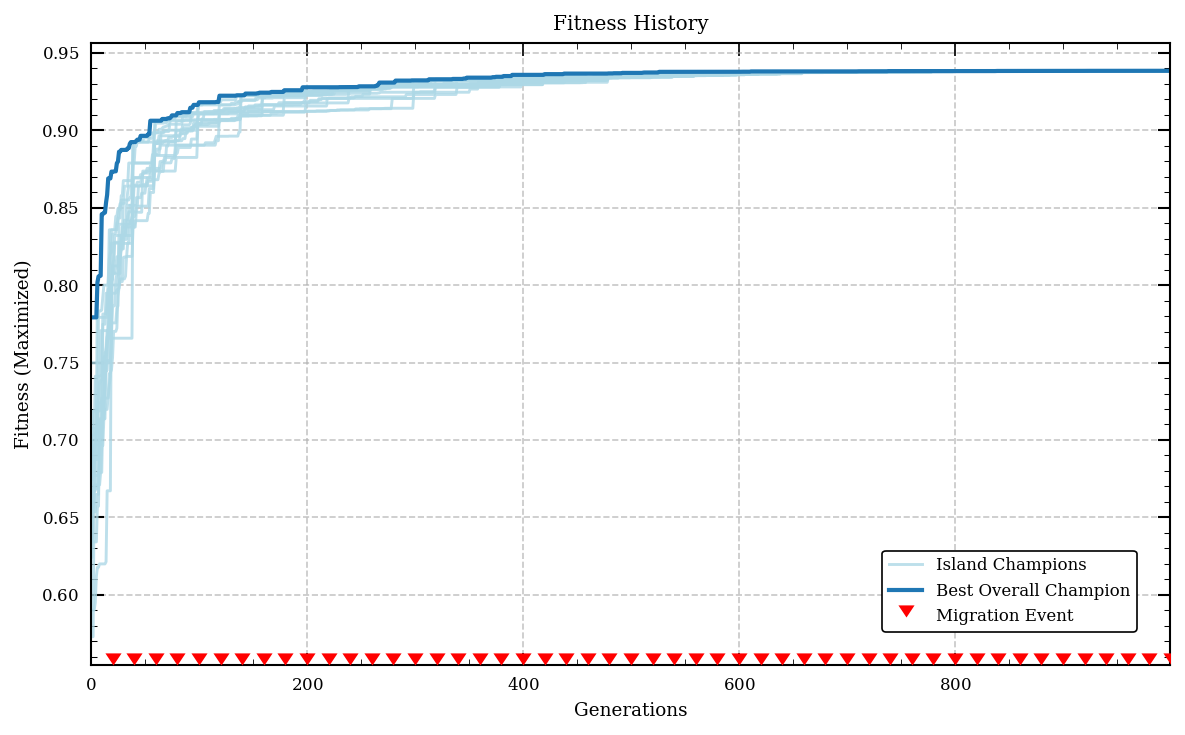

In [15]:
archipelago.plot_fitness_history()

In [16]:
best_layout, best_fitness = archipelago.get_best_single()

In [17]:
print(f"EIG_p (existing cable): {rayleigh_criterium(existing_cable):.2f}")
print(f"EIG_p (test cable): {rayleigh_criterium(test_cable_p):.2f}")
print(f"EIG_p (best layout): {rayleigh_criterium(best_layout):.2f}")

EIG_p (existing cable): 0.50
EIG_p (test cable): 0.11
EIG_p (best layout): 0.94


In [18]:
best_layout

DASLayout (Local Coords, 250 channels, 13 anchors, spacing≈10.00m, length=2500.37m, decay=0.40 dB/km, 1 field properties)

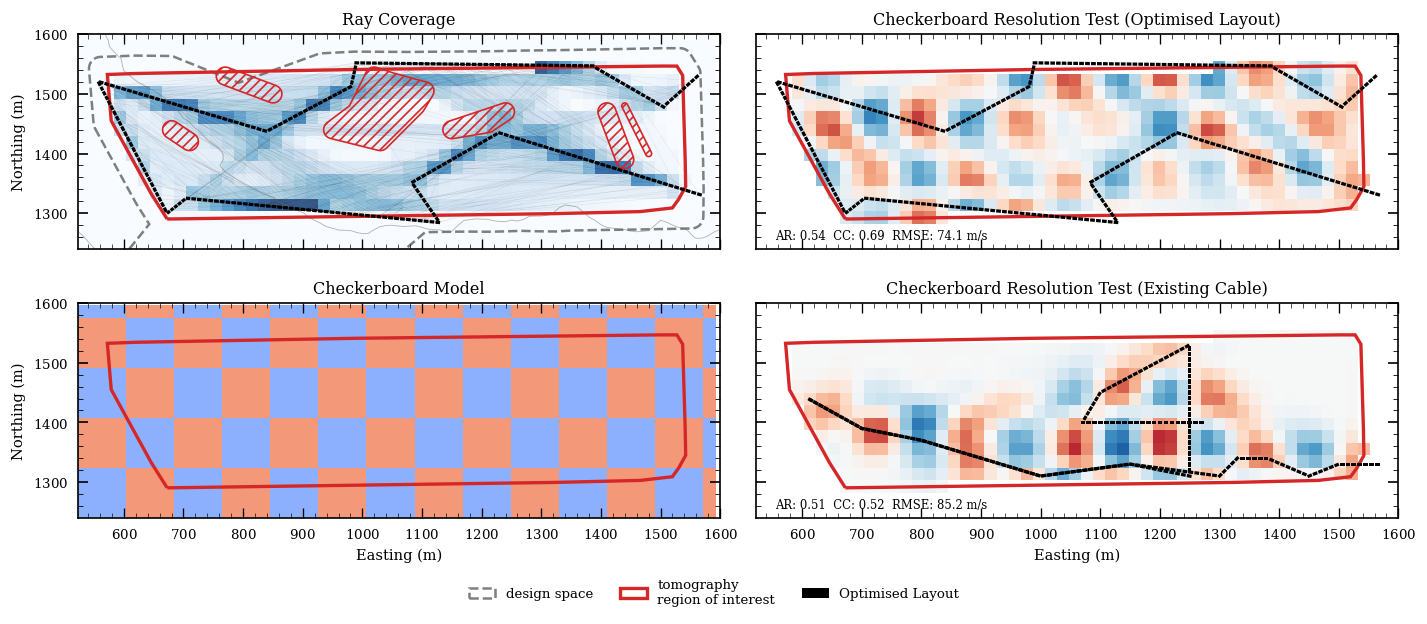

In [19]:
fig, ((ax2, ax1), (ax4, ax3)) = plt.subplots(
    2, 2, figsize=(12, 5), dpi=120, sharex=True, sharey=True
)


checkerboard_size = 4
background_velocity = 2000.0  # m/s
perturbation = 0.05  # 5% perturbation
sigma_d = 0.002
correlation_length = 30.0
regularization_weight = 2.5e-5

# Left subplot: Checkerboard plot
rayleigh_criterium.plot_checkerboard(
    design=best_layout,
    background_velocity=background_velocity,
    perturbation=perturbation,
    checkerboard_size=checkerboard_size,
    vmin=1800,
    vmax=2200,
    sigma_d=sigma_d,
    correlation_length=correlation_length,
    regularization_weight=regularization_weight,
    ax=ax1,
)

ax1.set_title("Checkerboard Resolution Test (Optimised Layout)")

ax1.set_aspect("equal")

# Right subplot: Ray coverage plot
rayleigh_criterium.plot(
    design=best_layout,
    ax=ax2,
    alpha=0.8,
)

# Get filtered rays and plot source-receiver connections (downsampled)
src_points, rec_points = rayleigh_criterium._get_filtered_rays(best_layout)
# Downsample rays for visualization (every 5th ray)
for i, (src, rec) in enumerate(zip(src_points[::20], rec_points[::20])):
    ax2.plot([src[0], rec[0]], [src[1], rec[1]], "k", alpha=0.15, linewidth=0.15)


ax3.set_xlabel("Easting (m)")
ax4.set_xlabel("Easting (m)")

ax2.set_ylabel("Northing (m)")
ax4.set_ylabel("Northing (m)")

ax2.set_title("Ray Coverage")


rayleigh_criterium.plot_checkerboard(
    existing_cable,
    background_velocity=background_velocity,
    perturbation=perturbation,
    checkerboard_size=checkerboard_size,
    vmin=1800,
    vmax=2200,
    sigma_d=sigma_d,
    correlation_length=correlation_length,
    regularization_weight=regularization_weight,
    ax=ax3,
)

ax3.set_title("Checkerboard Resolution Test (Existing Cable)")

for ax in (ax2,):
    # Add contour lines for elevation
    contour = ax.contour(
        topo_data.x,
        topo_data.y,
        topo_data.values.T,
        colors="dimgray",
        alpha=0.5,
        levels=[1600, 1800, 2000, 2200, 2400, 2600],
        linewidths=0.5,
    )

    plot_polygon(
        full_area,
        ax=ax,
        facecolor="none",
        edgecolor="tab:grey",
        linestyle="--",
        linewidth=1.5,
        label="design space",
        add_points=False,
    )

    for i, obstacle in enumerate(obstacles.geoms):
        plot_polygon(
            obstacle,
            ax=ax,
            facecolor="none",
            edgecolor="tab:red",
            linestyle="-",
            linewidth=1.0,
            add_points=False,
            zorder=10,
            hatch="////",
            hatch_linewidth=1.0,
        )


for ax in (ax1, ax2, ax3, ax4):
    plot_polygon(
        tomo_roi,
        ax=ax,
        facecolor="none",
        edgecolor="tab:red",
        hatch_linewidth=1.0,
        linestyle="-",
        linewidth=2.0,
        zorder=10,
        label="tomography\nregion of interest",
        add_points=False,
    )

    ax.set_xlim(x_range[0], x_range[1])
    ax.set_ylim(y_range[0], y_range[1])

    # Round ranges to the next multiple of 200
    x_start = np.ceil(x_range[0] / 100) * 100
    x_end = np.ceil(x_range[1] / 100) * 100
    y_start = np.ceil(y_range[0] / 100) * 100
    y_end = np.ceil(y_range[1] / 100) * 100

    ax.set_xticks(np.arange(x_start, x_end + 1, 100))
    ax.set_yticks(np.arange(y_start, y_end + 1, 100))

    ax.set_aspect("equal")

# for ax in (ax1, ax3):
#     # Add gridlines for checkerboard
#     x_ticks = np.linspace(x_range[0], x_range[1], n_x + 1)
#     y_ticks = np.linspace(y_range[0], y_range[1], n_y + 1)
#     # Adjust gridlines for checkerboard
#     x_ticks = x_ticks[::4]
#     y_ticks = y_ticks[::4]


#     for x in x_ticks:
#         ax.axvline(x, color='k', linestyle='-', linewidth=0.5, alpha=1.0)
#     for y in y_ticks:
#         ax.axhline(y, color='k', linestyle='-', linewidth=0.5, alpha=1.0)

existing_cable.plot(
    ax=ax3,
    plot_style="channels",
    color="k",
    label="Optimised Layout",
    zorder=10,
    width=0.005,
)


for ax in (ax1, ax2):
    best_layout.plot(
        ax=ax,
        plot_style="channels",
        color="k",
        label="Optimised Layout",
        zorder=10,
        width=0.005,
    )

x_nodes = np.linspace(x_range[0], x_range[1], n_x + 1)
y_nodes = np.linspace(y_range[0], y_range[1], n_y + 1)

X, Y = np.meshgrid(x_nodes, y_nodes, indexing="ij")
coord_list = np.stack([X.flatten(), Y.flatten()], axis=1)

m_true = np.ones((n_x, n_y))
for i in range(n_x):
    for j in range(n_y):
        if (i // checkerboard_size + j // checkerboard_size) % 2 == 0:
            m_true[i, j] = 1 / (
                background_velocity * (1 - perturbation)
            )  # Background slowness
        else:
            m_true[i, j] = 1 / (background_velocity * (1 + perturbation))

ax4.pcolormesh(
    X,
    Y,
    1 / m_true,
    cmap="coolwarm",
    vmin=1800,
    vmax=2200,
    zorder=-1,
)
ax4.set_title("Checkerboard Model")

# legend under ax1
handles, labels = ax2.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="center",
    bbox_to_anchor=(0.5, -0.01),
    ncol=3,
    frameon=False,
    fontsize=8,
)


fig.savefig("figures/rayleigh_tomo.png", dpi=300, bbox_inches="tight")
fig.savefig("figures/rayleigh_tomo.pdf", dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()

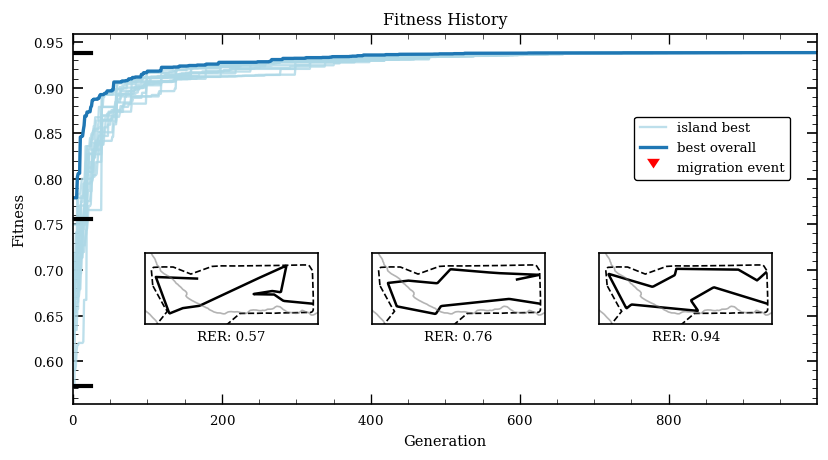

In [20]:
from shapely.affinity import translate

top_layouts, top_fitness = archipelago.get_n_spread_single(3, from_history=True)

fitness_history = archipelago.get_fitness_history()
num_generations = len(fitness_history)

fig = plt.figure(figsize=(8, 4), dpi=120)
gs = fig.add_gridspec(1, 1)
ax_hist = fig.add_subplot(gs[0])
fig.set_facecolor("w")

# fitness_history shape: (n_generations, n_islands)
best_overall = np.max(fitness_history, axis=1)
for i in range(fitness_history.shape[1]):
    ax_hist.plot(
        fitness_history[:, i],
        color="lightblue",
        alpha=0.8,
        label="island best" if i == 0 else None,
    )
ax_hist.plot(best_overall, lw=2, label="best overall", color="tab:blue")

mig_gens = np.arange(
    archipelago.migrate_every, num_generations + 1, archipelago.migrate_every
)
mig_indices = mig_gens[mig_gens <= num_generations]
if mig_indices.size > 0:
    ax_hist.scatter(
        mig_indices,
        [np.min(fitness_history) - 0.05] * len(mig_indices),
        marker=7,
        linewidth=0,
        color="red",
        s=60,
        zorder=5,
        label="migration event",
    )
    ax_hist.set_ylim(bottom=np.min(fitness_history))

ax_hist.set_xlim(left=0, right=num_generations - 1)
ax_hist.set_title("Fitness History")
ax_hist.set_xlabel("Generation")
ax_hist.set_ylabel("Fitness")
ax_hist.legend(loc="upper right", bbox_to_anchor=(1, 0.85))

# Add checkerboard insets, smaller and filling from 0.3 to 1.0 of figure width
inset_width = 0.18
inset_height = 0.3
n_layouts = len(top_layouts)
start = 0.2
end = 1.0
if n_layouts > 1:
    step = (end - start - inset_width * 0.5) / (n_layouts)
else:
    step = 0
for idx, proposal_layout in enumerate(top_layouts):
    left = start + idx * step
    bottom = 0.2
    ax_inset = fig.add_axes([left, bottom, inset_width, inset_height])

    proposal_layout.plot(ax=ax_inset, plot_style="line", color="k", linewidth=1.5)
    plot_polygon(
        full_area,
        ax=ax_inset,
        facecolor="none",
        edgecolor="k",
        linestyle="--",
        linewidth=1.0,
        label="shoulder area",
        add_points=False,
    )

    contour = ax_inset.contour(
        topo_data.x,
        topo_data.y,
        topo_data.values.T,
        colors="dimgray",
        alpha=0.5,
        levels=[1600, 1800, 2000, 2200, 2400, 2600],
        linewidths=1.0,
    )

    for i, obstacle in enumerate(obstacles.geoms):
        obstacle = translate(obstacle, xoff=550, yoff=-400)
        plot_polygon(
            obstacle,
            ax=ax,
            facecolor="none",
            edgecolor="tab:red",
            linestyle="-",
            linewidth=1.0,
            add_points=False,
            zorder=10,
            hatch="////",
            hatch_linewidth=1.0,
        )

    ax_inset.set_xticks([])
    ax_inset.set_yticks([])
    ax_inset.set_aspect("equal")

    ax_inset.set_xlabel(
        f"RER: {top_fitness[idx]:.2f}",
        fontsize=8,
    )

    ax_inset.set_ylim(1200, 1650)
    ax_inset.set_xlim(500, 1600)

    ax_hist.axhline(
        top_fitness[idx],
        0,
        0.025,
        color="k",
        linestyle="-",
        linewidth=2.5,
    )


ax_hist.set_ylim(np.min(fitness_history) - 0.02, np.max(fitness_history) + 0.02)

plt.show()


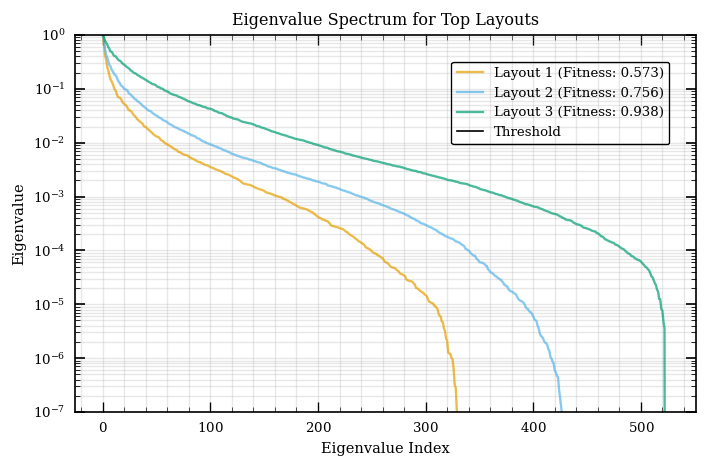

In [21]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=120)

for i, layout in enumerate(top_layouts):
    eigenvalues = rayleigh_criterium.get_eigenvalue_spectrum(layout)
    ax.plot(
        eigenvalues, label=f"Layout {i+1} (Fitness: {top_fitness[i]:.3f})", alpha=0.7
    )

ax.axhline(y=1e-10, color="k", linestyle="-", linewidth=1.0, label="Threshold")

ax.set_xlabel("Eigenvalue Index")
ax.set_ylabel("Eigenvalue")
ax.set_title("Eigenvalue Spectrum for Top Layouts")

ax.set_ylim(1e-7, 1e0)
ax.set_yscale("log")  # Eigenvalues often span orders of magnitude

ax.grid(True, which="both", ls="-", alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

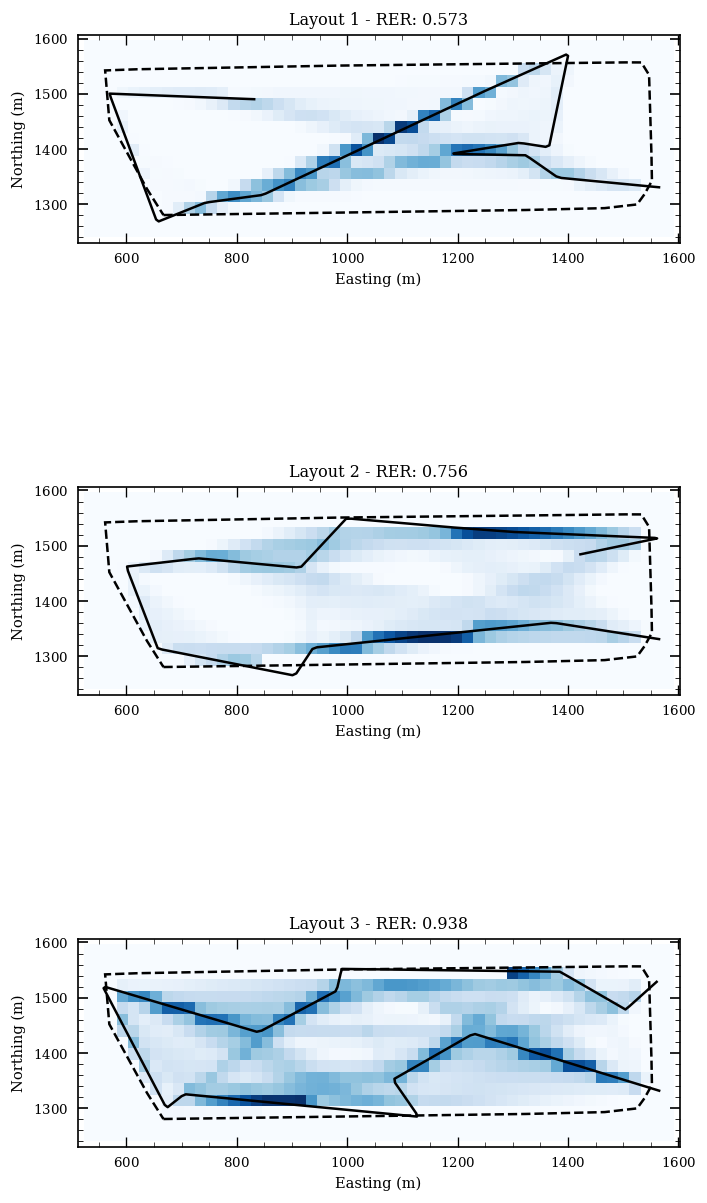

In [22]:
fig, axes = plt.subplots(3, 1, figsize=(6, 12), dpi=120)
axes = axes.flatten()

for i, (layout, fitness) in enumerate(zip(top_layouts, top_fitness)):
    ax = axes[i]

    # Plot checkerboard
    rayleigh_criterium.plot(design=layout, ax=ax)

    # Plot layout
    layout.plot(
        ax=ax, plot_style="line", color="k", linewidth=1.5, label="Optimised Layout"
    )

    # Plot shoulder area
    plot_polygon(
        shoulder_area,
        ax=ax,
        facecolor="none",
        edgecolor="black",
        linestyle="--",
        linewidth=1.5,
        label="Shoulder Area",
        add_points=False,
    )

    ax.set_title(f"Layout {i+1} - RER: {fitness:.3f}")
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")

    buffer = 50
    ax.set_xlim(shoulder_area.bounds[0] - buffer, shoulder_area.bounds[2] + buffer)
    ax.set_ylim(shoulder_area.bounds[1] - buffer, shoulder_area.bounds[3] + buffer)

    ax.set_aspect("equal")

plt.tight_layout()
plt.show()

In [23]:
import time

# Benchmark single criterion evaluation
n_trials = 10
times = []

print("Benchmarking criterion evaluation...")
for i in range(n_trials):
    start = time.time()
    fitness = rayleigh_criterium(best_layout)
    end = time.time()
    times.append(end - start)

avg_time = np.mean(times)
std_time = np.std(times)

print(f"\nAverage evaluation time: {avg_time:.4f} ± {std_time:.4f} seconds")
print(f"Minimum: {np.min(times):.4f} seconds")
print(f"Maximum: {np.max(times):.4f} seconds")

Benchmarking criterion evaluation...



Average evaluation time: 0.2341 ± 0.0174 seconds
Minimum: 0.2101 seconds
Maximum: 0.2676 seconds


In [24]:
# Calculate total CPU hours for optimization
n_islands = archipelago.n_islands
population_size = archipelago.population_size
n_generations = 1000  # From the optimize call

# Total evaluations
total_evaluations = n_islands * population_size * n_generations

# Total time in seconds
total_time_seconds = total_evaluations * avg_time

# Convert to hours
total_time_hours = total_time_seconds / 3600

# Convert to CPU hours (sequential processing)
cpu_hours = total_time_hours

print("\n" + "="*60)
print("COMPUTATIONAL COST ESTIMATION")
print("="*60)
print(f"\nOptimization Configuration:")
print(f"  - Number of islands: {n_islands}")
print(f"  - Population size per island: {population_size}")
print(f"  - Number of generations: {n_generations}")
print(f"  - Average evaluation time: {avg_time:.4f} seconds")

print(f"\nTotal Evaluations:")
print(f"  - Per generation: {n_islands * population_size:,}")
print(f"  - Total: {total_evaluations:,}")

print(f"\nComputational Time:")
print(f"  - Total sequential time: {total_time_seconds:,.1f} seconds ({total_time_hours:.2f} hours)")
print(f"  - If parallelized across {n_islands} islands: {total_time_hours/n_islands:.2f} hours")
print(f"  - Total CPU hours: {cpu_hours:.2f}")

print(f"\nTime Breakdown:")
print(f"  - Per generation (sequential): {n_islands * population_size * avg_time:.2f} seconds ({n_islands * population_size * avg_time/60:.2f} minutes)")
print(f"  - Per generation (parallelized): {population_size * avg_time:.2f} seconds ({population_size * avg_time/60:.2f} minutes)")

print("="*60)


COMPUTATIONAL COST ESTIMATION

Optimization Configuration:
  - Number of islands: 16
  - Population size per island: 128
  - Number of generations: 1000
  - Average evaluation time: 0.2341 seconds

Total Evaluations:
  - Per generation: 2,048
  - Total: 2,048,000

Computational Time:
  - Total sequential time: 479,536.1 seconds (133.20 hours)
  - If parallelized across 16 islands: 8.33 hours
  - Total CPU hours: 133.20

Time Breakdown:
  - Per generation (sequential): 479.54 seconds (7.99 minutes)
  - Per generation (parallelized): 29.97 seconds (0.50 minutes)
